In [9]:
from functools import partial
import json
from urllib.request import Request, urlopen
from urllib.parse import urlencode

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from shapely.geometry import Point
import geopandas as gpd

import geocoder
from fake_useragent import UserAgent

In [6]:
def load_station_data():
    station_data = pd.read_csv('./stations.csv',
                               usecols=['Site Name', 'Latitude', 'Longitude'])
    geometry = [Point(lat, long)
                for *_, lat, long in station_data.itertuples()]
    station_data = gpd.GeoDataFrame(station_data, geometry=geometry)
    station_data.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
    station_data.set_index('Site Name', inplace=True)
    station_data.index.name = 'site_name'

    usecols = [
        'Nitrogen oxides in air',
        'Nitrogen dioxide in air',
        'Nitrogen monoxide in air',
        'PM10 in aerosol',
        'Particulate matter under 2.5 micro m (aerosol)',
        'Ozone in air'
    ]
    colnames = ['NOX', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3']
    url = 'https://uk-air.defra.gov.uk/sos-ukair/api/v1/stations'

    request = Request(url, headers={'header': UserAgent().random})
    with urlopen(request) as response:
        text = response.read().decode()
        stations_json = json.loads(text)
        stations_json = [record['properties'] for record in stations_json]

    stations = pd.DataFrame(stations_json)
    station_re = '((?:' + ')|(?:'.join(station_data.index) + '))[- ]?'
    stations[['site_name', 'pollutant']] = stations.label.str.split(
        station_re, expand=True).loc[:, 1:]
    stations.dropna(inplace=True)
    station_ids = stations.pivot_table(
        index='site_name',
        columns='pollutant',
        values='id',
        aggfunc=lambda x: ','.join([str(i) for i in x])
    )
    station_ids = station_ids[usecols]
    station_ids.columns = colnames
    station_ids.dropna(how='all', inplace=True)
    station_ids = station_data.join(station_ids, how='right')
    return station_ids

In [7]:
station_data = load_station_data()

In [12]:
def get_timeseries_ids(station_id):
    station_url = 'https://uk-air.defra.gov.uk/sos-ukair/api/v1/stations/{:d}'
    request = Request(station_url.format(int(station_id)))
    with urlopen(request) as response:
        station_data = json.loads(response.read().decode())
        return list(station_data['properties']['timeseries'].keys())


def get_timeseries_data(station_ids):
    timeseries_url = 'https://uk-air.defra.gov.uk/sos-ukair/api/v1/timeseries/{}/getData'
    ts_data = []
    codes = []
    for st_id in station_ids.split(','):
        for ts_id in get_timeseries_ids(st_id):
            request = Request(timeseries_url.format(ts_id),
                              headers={'header': UserAgent().random})
            with urlopen(request) as response:
                if str(response.code).startswith('2'):
                    vals = json.loads(response.read().decode())['values']
                    ts_data += vals
    ts_data = pd.DataFrame(ts_data)
    ts_data[ts_data == -99] = np.nan
    ts_data.timestamp = pd.to_datetime(ts_data.timestamp, unit='ms')
    ts_data.set_index('timestamp', inplace=True)
    return ts_data


def get_nearest_station(location, all_stations):
    best = all_stations.distance(location).sort_values()
    return best.index[0]


def get_nearest_timeseries(location, pollutant, data):
    nearest = get_nearest_station(location, data)
    if not isinstance(pollutant, (list, tuple, np.ndarray)):
        pollutant = [pollutant, ]
    all_ts = []
    for poll in pollutant:
        sp_id = data.loc[nearest, poll]
        if sp_id is None:
            raise ValueError('No data on {} for {}'.format(poll, nearest))
        ts = get_timeseries_data(sp_id)
        ts[poll] = ts.pop('value')
        all_ts.append(ts)
    return nearest, pd.concat(all_ts, axis=1)

nearest station to Firth Court, Western Bank, Sheffield is Sheffield Devonshire Green


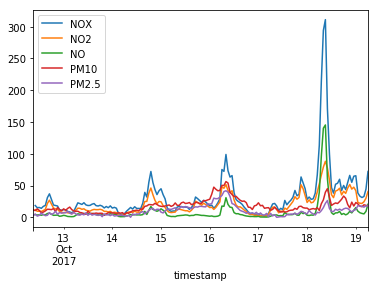

In [16]:
def plot_from_geo_string(string_loc, station_data):
    lat, long = geocoder.arcgis(string_loc).latlng
    sta, ts = get_nearest_timeseries(
        Point(lat, long),
        ['NOX', 'NO2', 'NO', 'PM10', 'PM2.5'],
        station_data
    )
    print('nearest station to {} is {}'.format(string_loc, sta))
    ts.plot.line()
    plt.show()

plot_from_geo_string('Firth Court, Western Bank, Sheffield', station_data)